In [2]:
from Bio import SeqIO
human_genome = SeqIO.parse("GCA_000001405.28_GRCh38.p13_genomic.fna", "fasta")
for chromosome in human_genome:
    if chromosome.name == "CM000664.2":
        sequence = str(chromosome.seq).lower().encode('utf8')

p = 2_549_536_629_329
bits_48 = 2 ** 48 - 1
scale = 0x07ffffffff
from hashlib import sha256
import numpy as np
import multiprocessing as mp

def quick_min_hash(q,progress,a,range_l,range_r):
    # Set a min_list that has the largest hash values. Therefore, any hash value found later will be smaller than this list of values.
    min_list=[scale]*a
    # For each range of task (individual task distributed for each worker[explained in the loaddist function]), store the integer hash value of the entire sequence using sha256 function and take the reminder of bits_48 into a variable s256.
    for i in range(range_l,range_r):
        s256=int(sha256(sequence[i:i+15]).hexdigest(),16) % bits_48
        # Enumerate the min hash value list from index 1    
        for j,minval in enumerate(min_list,start=1):
            # Store the last couple digits of scale after multipling s256 with any index inside my min_list in a variable t. 
            t=((s256*j)%p)&scale
            # Compare t if t is smaller than the hash value in min_list. If yes, store the new hash value as t. 
            if t<min_list[j-1]:
                min_list[j-1]=t
        # Calculate the percentages of the progress after completing every 100,000 subsequences.
        if (i-range_l+1)%100000==0:
            progress.put(100000)
    progress.put((range_r-range_l)%100000)
    q.put(min_list) # Put the list of min hash value into the queue.

def loaddist(size,worker,start=0):
    # Evenly distribute the entire task for each worker.
    distrib=[size//worker]*worker
    # The size of the entire task (going through the 100 hash families) 
    # divided by my total workers will not be an interger (my computer has 8 cores 16 threads).
    # Thus, whatever left-off after division(remainders) will again evenly distributed to each worker.
    for i in range(size%worker):
        distrib[i]+=1
    i=start
    result=[]
    for size in distrib:
        result.append((i,i+size))
        i+=size
    return result

def estimate_value(a,seq):
    min_list=[scale]*a
    proc_list=[]
    queue_list=[]
    
    # Evenly distribute the task of loading all 15-mer subsequences to 16 workers.
    range_list=loaddist(len(seq)-14,16)
    print(range_list)
    
    # Store the queuing process in a progress bar.
    progbar=mp.Queue()

    for l,r in range_list:
        
        q=mp.Queue()
        # l=range_l, r=range_r
        p=mp.Process(target=quick_min_hash,args=(q,progbar,a,l,r))
        # Start the process 
        p.start()
        # Store results in the process and queue lists
        proc_list.append(p)
        queue_list.append(q)

    for i,p in enumerate(proc_list):    
    # Get the results by queuing each worker while looping through the process lsit
        for i,newval in enumerate(queue_list[i].get()):
            # Compare the new hash values with the original hash values in the min_list, storing the new min hash values
            if newval<min_list[i]:
                min_list[i]=newval
        min_arr = np.array(min_list)
        # End the process by joining the results from all workers 
        p.join()
        
    min_arr=min_arr/scale
    mean_hash_list=[]
    mean_hash=0
    total=0
    for count,hash in enumerate(min_arr,start=1):
        total+=hash
        mean_hash_list.append(total/count)
    mean_hash_list=np.array(mean_hash_list)
    mean_hash_estimates=(1/mean_hash_list)-1
    return mean_hash_estimates

test1 = sequence[0:1000000]

# Estimate distinct values for all 100 families in the first 1000000 protions:
test1_results = estimate_value(100,test1)
test1_results

[(0, 62500), (62500, 125000), (125000, 187499), (187499, 249998), (249998, 312497), (312497, 374996), (374996, 437495), (437495, 499994), (499994, 562493), (562493, 624992), (624992, 687491), (687491, 749990), (749990, 812489), (812489, 874988), (874988, 937487), (937487, 999986)]


array([ 922556.68357319, 1084706.53924834, 1222692.96952731,
       1135398.32975902, 1050800.51342871, 1153119.99138061,
       1141605.23763076, 1176364.96924683, 1189347.11236279,
       1034472.84341873, 1131014.5518426 , 1149660.39047853,
       1131261.15346412, 1060639.07800518, 1023213.22644892,
       1038806.85209876, 1077533.98480681, 1058671.28565266,
       1114512.21018748, 1165611.09067147, 1220845.56853313,
       1170960.57396639, 1141279.50955816, 1135370.19145491,
       1176720.10014671, 1112524.09046371, 1095998.23434587,
       1100779.98547468, 1133790.21880071, 1168608.8119644 ,
       1193118.97197072, 1165013.57205796, 1074866.58490521,
       1070894.28979771, 1087721.94858286, 1006153.77443337,
       1026361.70246057, 1037738.26923899, 1014942.41915701,
       1035010.3748797 , 1007372.42166546, 1030079.65958299,
       1028296.21499975,  998476.99905821, 1018444.87119545,
        980503.62655229,  987602.61456001, 1003919.951833  ,
        996124.95144467,

In [3]:
test1_sub=[test1[i:i+15] for i in range(len(test1)-14)]
print(f"There are {len(set(test1_sub))} true distinct subsequences in test1") 

There are 931157 true distinct subsequences in test1


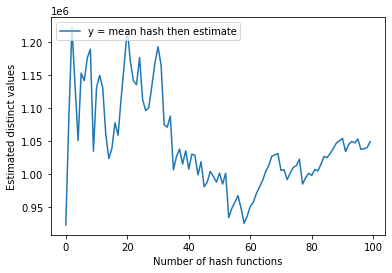

In [6]:
from matplotlib import pyplot as plt
x = np.arange(100)
plt.plot(x, test1_results)
plt.ylabel('Estimated distinct values')
plt.xlabel('Number of hash functions')
plt.legend(['y = mean hash then estimate', 'median hash then estimate', 'estimate then mean', 'estimate then median'], loc='upper left')
plt.show()

In [7]:
test1_estimate_100 = test1_results[-1]
test1_estimate_100

1048865.6405058529

In [8]:
test1_estimate_1 = test1_results[0]
test1_estimate_1 

922556.683573193

In [9]:
test1_estimate_10 = test1_results[9]
test1_estimate_10

1034472.843418727

In [10]:
# Estimate distinct values for all 100 families in the first 100000 protions:
test2 = sequence[0:100000]
test2_results = estimate_value(100,test2)
test2_results

[(0, 6250), (6250, 12500), (12500, 18749), (18749, 24998), (24998, 31247), (31247, 37496), (37496, 43745), (43745, 49994), (49994, 56243), (56243, 62492), (62492, 68741), (68741, 74990), (74990, 81239), (81239, 87488), (87488, 93737), (93737, 99986)]


array([127919.15862444,  95205.49483648,  63165.04443901,  82365.78878427,
        61174.16021569,  57481.20402602,  60485.32070493,  62526.21868588,
        63374.13601411,  65453.6635698 ,  51692.15266173,  52240.82253838,
        56028.78260898,  59365.46782722,  63100.83966464,  61411.39918274,
        62037.34807132,  65394.15749929,  67800.06491946,  68824.04747432,
        71425.59219595,  69676.61359859,  71717.10421665,  72075.34228028,
        71650.28689485,  74065.29401167,  73683.34422198,  76245.63131658,
        69703.3462676 ,  71659.29584151,  64270.57677614,  64984.89491452,
        65901.43903368,  65750.82237946,  67567.20714915,  68393.49270254,
        68893.12146992,  69466.33648537,  70690.94513863,  71458.52802245,
        69548.53173563,  69458.92950537,  70719.48827994,  69708.44592446,
        71043.8439423 ,  71502.72289346,  71836.95630326,  70577.34869662,
        69795.60934669,  69802.17379936,  71167.7680267 ,  71772.13372078,
        71720.72655578,  

In [12]:
test2_sub=[test2[i:i+15] for i in range(len(test2)-14)]
print(f"There are {len(set(test2_sub))} true distinct subsequences in test2") 

There are 87191 true distinct subsequences in test2


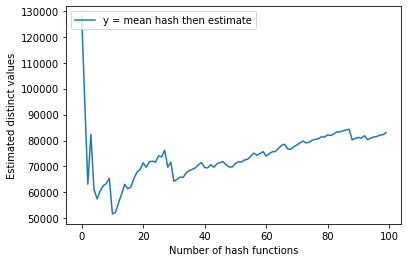

In [17]:
x = np.arange(100)
plt.plot(x, test2_results)
plt.ylabel('Estimated distinct values')
plt.xlabel('Number of hash functions')
plt.legend(['y = mean hash then estimate'], loc='upper left')
plt.show()

In [13]:
test2_estimate_100 = test2_results[-1]
test2_estimate_100

83027.71125458396

In [14]:
test2_estimate_1 = test2_results[0]
test2_estimate_1

127919.15862443828

In [18]:
seq_results = estimate_value(100,sequence)
seq_results

[(0, 15137095), (15137095, 30274190), (30274190, 45411285), (45411285, 60548380), (60548380, 75685475), (75685475, 90822570), (90822570, 105959665), (105959665, 121096760), (121096760, 136233855), (136233855, 151370950), (151370950, 166508045), (166508045, 181645139), (181645139, 196782233), (196782233, 211919327), (211919327, 227056421), (227056421, 242193515)]


array([6.60764189e+07, 9.85932224e+07, 1.42178227e+08, 1.27376230e+08,
       1.50305066e+08, 1.41107754e+08, 1.16304723e+08, 1.28990101e+08,
       1.43431189e+08, 1.33539596e+08, 1.08421434e+08, 1.04915231e+08,
       1.05597304e+08, 1.12496804e+08, 1.18373007e+08, 1.22713350e+08,
       1.08370231e+08, 1.12164542e+08, 1.16640169e+08, 1.22146243e+08,
       1.26145892e+08, 1.17761994e+08, 1.18909716e+08, 1.21681233e+08,
       1.23649554e+08, 1.27095346e+08, 1.30351683e+08, 1.32882965e+08,
       1.33391219e+08, 1.36204036e+08, 1.25889597e+08, 1.26192083e+08,
       1.21373513e+08, 1.22033960e+08, 1.22214516e+08, 1.22749883e+08,
       1.25810026e+08, 1.22139387e+08, 1.24364713e+08, 1.26870629e+08,
       1.29266770e+08, 1.30929868e+08, 1.32070147e+08, 1.33991711e+08,
       1.31814852e+08, 1.31416642e+08, 1.32033987e+08, 1.34425579e+08,
       1.35885970e+08, 1.34955766e+08, 1.36475595e+08, 1.35943573e+08,
       1.38126981e+08, 1.40371150e+08, 1.42938174e+08, 1.42889153e+08,
      

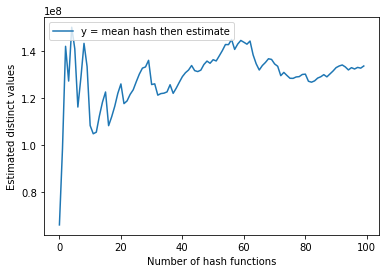

In [19]:
x = np.arange(100)
plt.plot(x, seq_results)
plt.ylabel('Estimated distinct values')
plt.xlabel('Number of hash functions')
plt.legend(['y = mean hash then estimate', 'median hash then estimate', 'estimate then mean', 'estimate then median'], loc='upper left')
plt.show()

In [20]:
seq_estimate_100 = seq_results[-1]
seq_estimate_100

133799603.23286605

In [21]:
seq_estimate_1 = seq_results[0]
seq_estimate_1

66076418.93653846

In [22]:
seq_estimate_10 = seq_results[9]
seq_estimate_10

133539596.22891568